In [41]:
import torch
import torchvision

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

data_tf = transforms.ToTensor()

train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_tf)

test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_tf)

print('Train data images: ', len(train_data))
print('Test data images: ', len(test_data))

Train data images:  60000
Test data images:  10000


In [42]:
BS = 20

train_loader = DataLoader(train_data, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BS, shuffle=True)
print(len(test_loader)) #Number of batches
print(len(train_loader)) #Number of batches

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch)
    break


500
3000
torch.Size([20, 1, 28, 28]) tensor([3, 4, 1, 9, 0, 1, 1, 8, 6, 7, 6, 7, 9, 4, 7, 7, 2, 5, 3, 0])


(20, 1, 28, 28) torch.Size([20])


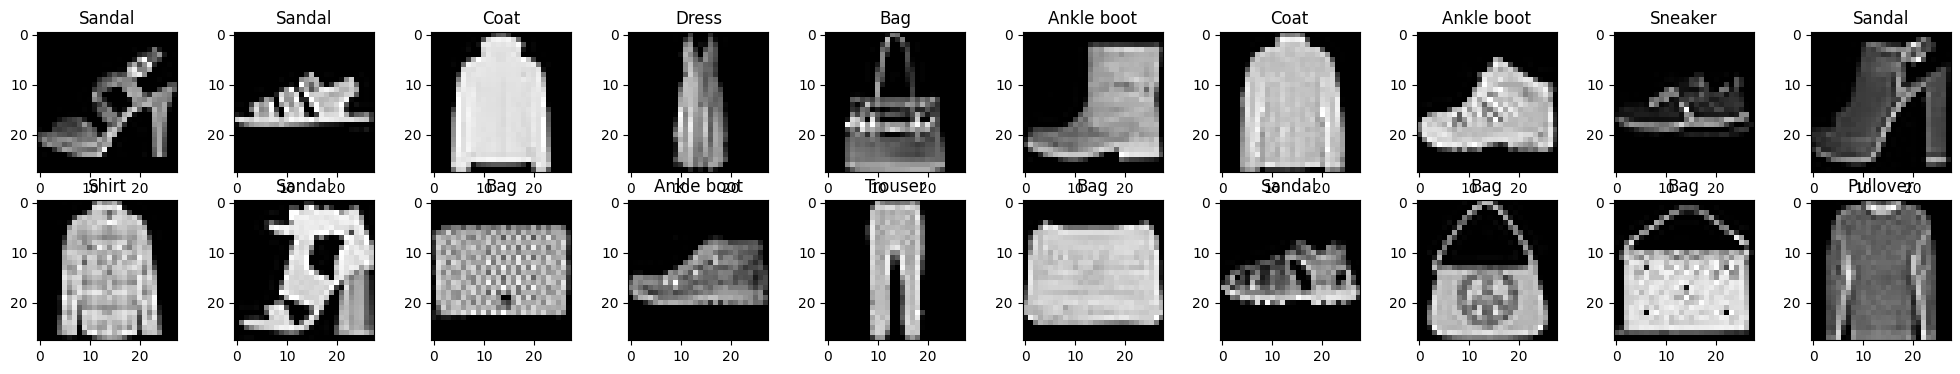

In [43]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# one batch of training images
dataiter = iter(train_loader)

images, labels = next(dataiter)
images = images.numpy()

print(images.shape, labels.shape)

fig = plt.figure(figsize=(25, 4))
for i in np.arange(BS):
    ax = fig.add_subplot(2, int(BS/2), i+1)
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(classes[labels[i]])


In [44]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)

        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # after another pool layer this becomes (20, 5, 5);
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*5*5, 50)
        self.drop_1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.drop_1(x)
        x = self.fc2(x)

        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (drop_1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [45]:
import torch.optim as optim

loss_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), 0.001)

In [46]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = net(images)

    predicted = torch.argmax(outputs.detach(), dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print('Accuracy before training: ', accuracy)

Accuracy before training:  9.79


In [47]:
def train(n_epochs):

    main_loss = []

    for epoch in range(n_epochs):

        running_loss = 0.0

        for i, data in enumerate(train_loader):

            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = loss_criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 1000 == 999:
                average_loss = running_loss/1000
                main_loss.append(average_loss)
                print('Epoch: {}, Batch №: {}, Average Loss: {}'.format(epoch + 1, i+1, average_loss))
                running_loss = 0.0

    print('Trainnig complete')
    return main_loss

In [48]:
num_epochs = 10

train_loss = train(num_epochs)

Epoch: 1, Batch №: 1000, Average Loss: 1.0172201979756355
Epoch: 1, Batch №: 2000, Average Loss: 0.7334625310450792
Epoch: 1, Batch №: 3000, Average Loss: 0.6726990317702294
Epoch: 2, Batch №: 1000, Average Loss: 0.6345971103012562
Epoch: 2, Batch №: 2000, Average Loss: 0.5958022764921188
Epoch: 2, Batch №: 3000, Average Loss: 0.5678560400567949
Epoch: 3, Batch №: 1000, Average Loss: 0.5518027107268572
Epoch: 3, Batch №: 2000, Average Loss: 0.5265595638751983
Epoch: 3, Batch №: 3000, Average Loss: 0.5161828395426273
Epoch: 4, Batch №: 1000, Average Loss: 0.5062166922092438
Epoch: 4, Batch №: 2000, Average Loss: 0.4951785119175911
Epoch: 4, Batch №: 3000, Average Loss: 0.48190006928890944
Epoch: 5, Batch №: 1000, Average Loss: 0.47374300917983053
Epoch: 5, Batch №: 2000, Average Loss: 0.4750530282072723
Epoch: 5, Batch №: 3000, Average Loss: 0.4632019919790328
Epoch: 6, Batch №: 1000, Average Loss: 0.4510492098201066
Epoch: 6, Batch №: 2000, Average Loss: 0.4425492065027356
Epoch: 6, Ba

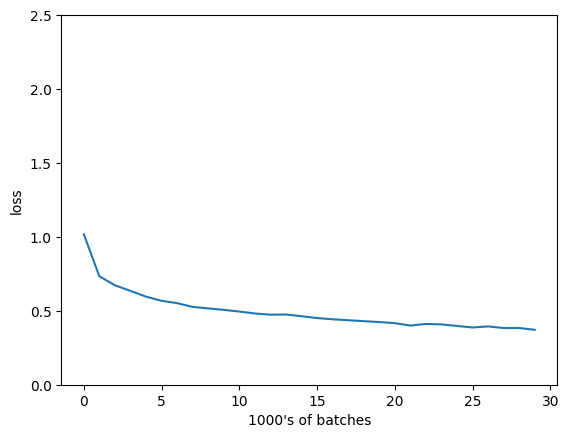

In [49]:
plt.plot(train_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.show()

In [50]:
average_test_loss = 0.
correct_classes = list(0. for i in range(10))
total_classes = list(0. for i in range(10))

net.eval()

for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = net(inputs)

    loss = loss_criterion(outputs, labels)

    test_loss = ((i)*test_loss+loss.data)/(i+1)

    predicted = torch.argmax(outputs.data, dim=1)

    for i in range(BS):
        label = labels.data[i]
        if (predicted[i]==label):
          correct_classes[label] += 1
        total_classes[label] += 1

print('Test Loss: {}\n'.format(test_loss.numpy()[0]))

for i in range(10):
  print('Test Accuracy of {}: {}% ({}/{})'.format(
      classes[i], 100 * correct_classes[i] / total_classes[i],
      int(correct_classes[i]), int(total_classes[i])))

print('\nTest Accuracy: {}% ({}/{})'.format(
    100. * np.sum(correct_classes) / np.sum(total_classes),
    int(np.sum(correct_classes)), int(np.sum(total_classes))))

Test Loss: 0.3283255994319916

Test Accuracy of T-shirt/top: 87.9% (879/1000)
Test Accuracy of Trouser: 96.5% (965/1000)
Test Accuracy of Pullover: 88.0% (880/1000)
Test Accuracy of Dress: 88.9% (889/1000)
Test Accuracy of Coat: 79.1% (791/1000)
Test Accuracy of Sandal: 96.8% (968/1000)
Test Accuracy of Shirt: 59.4% (594/1000)
Test Accuracy of Sneaker: 93.9% (939/1000)
Test Accuracy of Bag: 97.3% (973/1000)
Test Accuracy of Ankle boot: 97.5% (975/1000)

Test Accuracy: 88.53% (8853/10000)
